#Image Classification Project

#Introduction

#### This notebook will apply an image classification algorithm onto an image set to identify which images in the dataset are of dogs, and which are of cats.

# PreProcessing

#### Import relevant packages

In [14]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import keras
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow_datasets as tfds
from keras import layers
from keras.applications import MobileNetV2
from tensorflow import data as tf_data

#### Load the cats_vs_dogs image set from the tfds package. These images contain labeled pictures of cats and dogs, which our model will classify. Only a fraction of the data will be loaded in due to RAM contraints in Colab Notebook

In [5]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[10%:12%]", "train[10%:]"],
    as_supervised=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.AVPBPZ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


#### To make sure our info has loaded in correctly, we are going to load up some example pictures and their labels from the image set

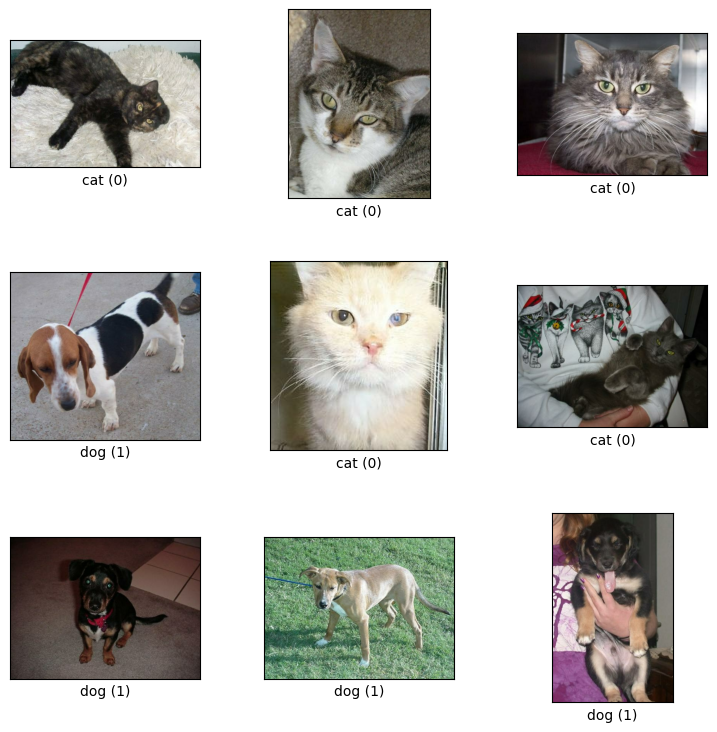

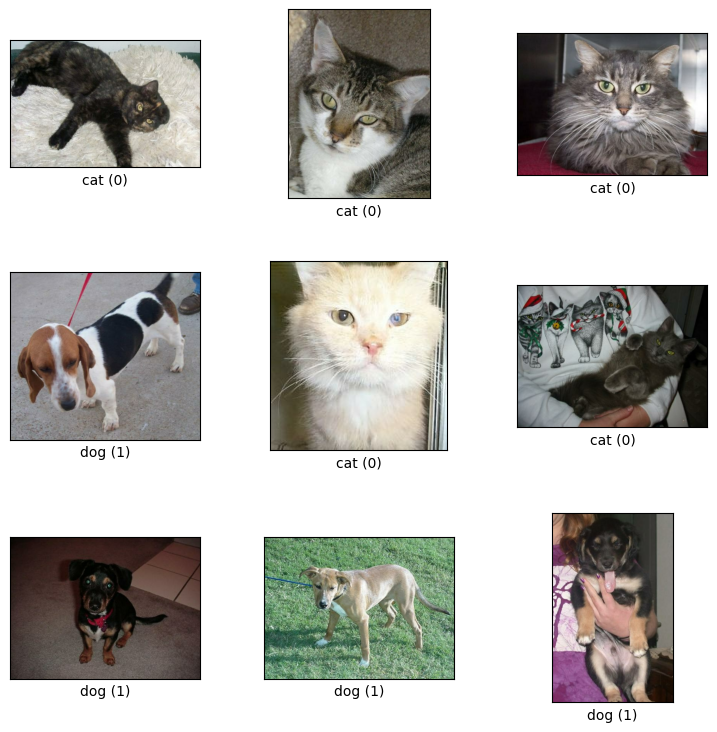

In [6]:
datasets, ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[10%:12%]", "train[12%:]"],
    as_supervised=True,
    with_info=True
)
train_ds, validation_ds, test_ds = datasets

tfds.visualization.show_examples(validation_ds, ds_info)

#### The images seem to have loaded properly, displaying cats and dogs with their respective labels

# Model Creation and Analysis

### For this project we will use transfer learning using the MobileNetV2 model to classify our image set. MobileNetV2 is a neural network which has already been created, which we can apply to our own cats vs. dogs image set. To use MobileNetV2 we first need to resize our images so that MobileNetV2 can process them.

In [7]:
resize_fn = keras.layers.Resizing(224, 224)
train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

#### Now that images are resized, we will apply random transformations to the images (i.e. rotations) to prevent overfitting and introduce our model to different aspects of the image set. We are then going to re-save this modified image set as our training data.

In [8]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

### Next, we will split up our training, validation, and test data into batches of 60

In [9]:
batch_size = 60

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

#### Load MobileNetV2 to use on our image set. Input shape includes the size of our image (224 x 224) and the number of color dimensions, being 3 (red, green, blue).

In [10]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


#### Load in the rest of MobileNetV2. After experimentation, a dropout rate of 0.2 was found to bring out the highest accuracy of the end model.

In [11]:
inputs = keras.Input(shape=(224, 224, 3)) #Change 1 to 3 for non grayscale
scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  #test different values
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

#### The output demonstrates that the imported model has over 2 million parameters. We will now apply this model to our cats vs. dogs image set.

#### First, we will fit the top layer of the model

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
39/39 [==============================] - 135s 3s/step - loss: 0.4852 - accuracy: 0.8005 - val_loss: 0.0966 - val_accuracy: 0.9613
Epoch 2/2
39/39 [==============================] - 115s 3s/step - loss: 0.1109 - accuracy: 0.9626 - val_loss: 0.0738 - val_accuracy: 0.9742


#### Our top layer has a high accuracy at ~96%, and ~97% accuracy on the validation set. Finally, we will fit the end to end model.

In [13]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-6),  #Mess with this learning rate to see if I can optimize the model
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

epochs = 2
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

# Conclusion

#### Our model has ~97.5% accuracy, meaning it is able to correctly classify images as either 'cat' or 'dog' about 97.5% of the time. The accuracy on the validation set is ~98%, which is also very high. This shows that our model is effective at classifying images as cat or dog.